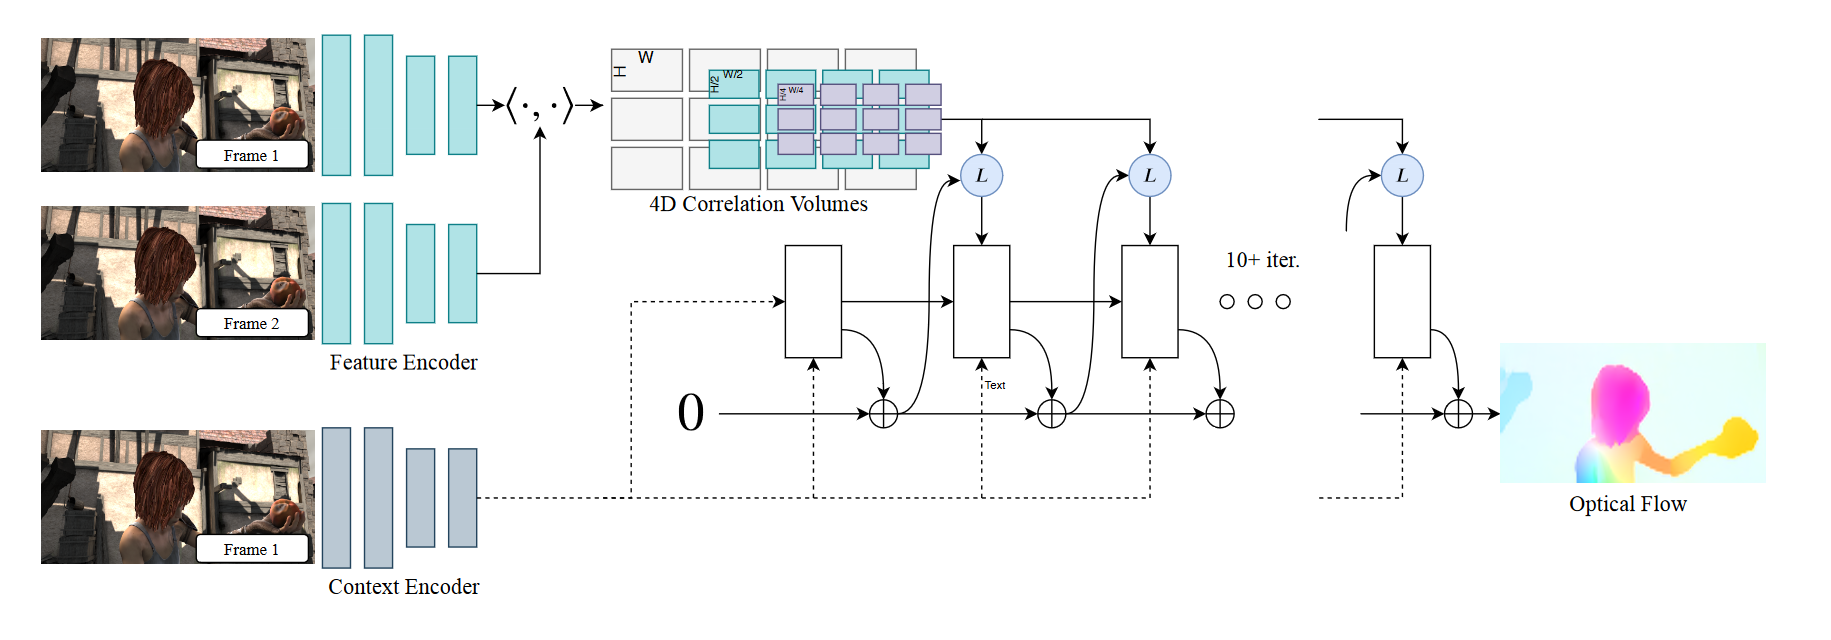


# Optical Flow:  RAFT 
RAFT es una arquitectura de red neuronal profunda para la estimación de flujo óptico. RAFT extrae características por píxel, construye volúmenes de correlación 4D a múltiples escalas para todas las parejas de píxeles y actualiza iterativamente un campo de flujo a través de una unidad recurrente que realiza búsquedas en los volúmenes de correlación.

https://arxiv.org/pdf/2003.12039.pdf

Necesario instalar PyAV:
pip install av

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from pathlib import Path
from urllib.request import urlretrieve
import cv2


plt.rcParams["savefig.bbox"] = "tight"



def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Hace una matriz
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

Elegimos dos partes del vídeo para ver las diferencias.
Para ello elegimos el frame 100 y 101 y el frame 150 y 151

c:\Users\gerar\anaconda3\envs\aa1\lib\site-packages\torchvision\io\video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


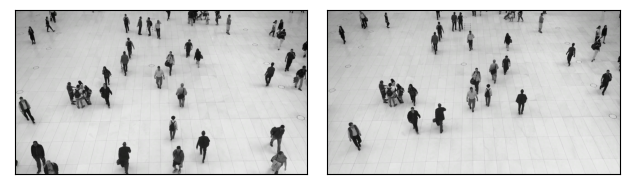

In [2]:
from torchvision.io import read_video
frames, _, _ = read_video("../videos/people2.mp4")
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

El modelo RAFT trabaja directamente con las imagenes RGB tipo flotante con valores de [-1 a 1], pero el video que tenemos descargado son imagenes con valores entre 0 y 255 tipo entero. Además nos interesa reducir el tamaño para ir más rápido.

In [3]:

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # pasa [0, 1] a [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch

#verificamos el tipo de imagen de entrada
print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

#usamos cuda para ir más rapido
device = "cuda" if torch.cuda.is_available() else "cpu"

#preposesamos la imágen
img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

#verificamos que el tipo de imagen que obtenemos cumple con el tipo que necesita de entrada el modelo
print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 720, 1280]), dtype = torch.uint8
shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


## Estimando el Flujo óptico usando RAFT 
se usa la implentación `~torchvision.models.optical_flow.raft_large`, que se basa en el algoritmo publicado en 2020 en ` <https://arxiv.org/abs/2003.12039>`_.



In [4]:
from torchvision.models.optical_flow import raft_large #se puede cambiar "raft_large" por "raft_small" para ir más rápido, pero peor resultado

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

c:\Users\gerar\anaconda3\envs\aa1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gerar\anaconda3\envs\aa1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to C:\Users\gerar/.cache\torch\hub\checkpoints\raft_large_C_T_SKHT_V2-ff5fadd5.pth


type = <class 'list'>
length = 12 = number of iterations of the model


In [5]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -5.9385271072387695, max = 6.019962310791016


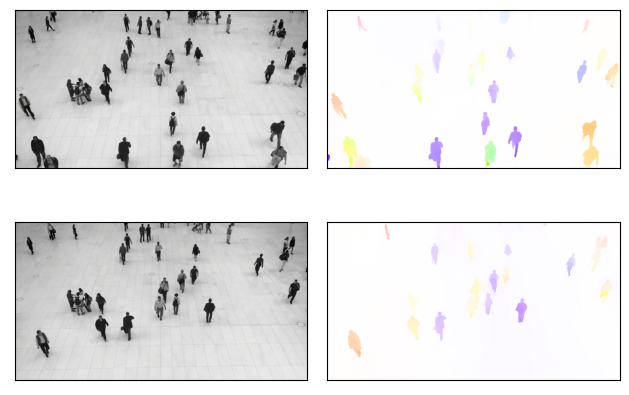

In [6]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)


img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)


### IMPLEMENTACIÓN CON YOLO

In [2]:
import cv2 as cv
import torch
import numpy as np
from torchvision.models.optical_flow import raft_large
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.utils import flow_to_image
from ultralytics import YOLO
import time
import matplotlib.pyplot as plt
from savedata import SaveData

In [3]:
def get_hand(img, model, person_idx=3):
    detections = model(img)
    keypoints = detections[0].keypoints
    keypoint_coordinates = keypoints[person_idx].xy[0]
    right_wrists = keypoint_coordinates[10]
    return int(right_wrists[0]), int(right_wrists[1])

In [4]:
def preprocess(batch):
    # Preprocesamiento para RAFT: conviertes a float32, normalizas y cambias tamaño
    transforms = T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5), # De [0,1] a [-1,1]
        T.Resize(size=(520, 960)),      # Ajusta a dimensiones requeridas (ejemplo)
    ])
    return transforms(batch)

In [ ]:
video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()
if not status:
    raise RuntimeError("No se pudo leer el video.")
size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('videos/video_raft.mp4', fourcc, 20.0, size) 

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# Obtener la posición inicial de la mano
hand_point = get_hand(old_frame, model)

device = "cuda" if torch.cuda.is_available() else "cpu"
old_tensor = preprocess(F.to_tensor(old_frame).unsqueeze(0)).to(device)

# Cargar RAFT
raft_model = raft_large(pretrained=True, progress=False).to(device)
raft_model.eval()

scale_x = 960 / size[0]  # ancho
scale_y = 520 / size[1]  # alto

tracking_path = [hand_point]  # Lista para almacenar la trayectoria de la mano
compute_start = time.time()

while True:
    status, frame = video.read()
    if not status:
        break

    new_tensor = preprocess(F.to_tensor(frame).unsqueeze(0)).to(device)

    with torch.no_grad():
        flow_list = raft_model(old_tensor, new_tensor)
    predicted_flow = flow_list[-1]

    flow_img = flow_to_image(predicted_flow)
    flow_img = flow_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    flow_img = (flow_img * 255).astype(np.uint8)

    x_scaled = int(hand_point[0] * scale_x)
    y_scaled = int(hand_point[1] * scale_y)

    x_scaled = max(0, min(flow_img.shape[1]-1, x_scaled))
    y_scaled = max(0, min(flow_img.shape[0]-1, y_scaled))

    flow_x = predicted_flow[0, 0, y_scaled, x_scaled].item()
    flow_y = predicted_flow[0, 1, y_scaled, x_scaled].item()

    new_hand_x = hand_point[0] + (flow_x / scale_x)
    new_hand_y = hand_point[1] + (flow_y / scale_y)
    hand_point = (int(new_hand_x), int(new_hand_y))

    # Guardar posición actual en la trayectoria
    tracking_path.append(hand_point)

    # Dibujar el punto de la mano con el color del flujo
    hand_color = flow_img[y_scaled, x_scaled].tolist()  # BGR
    cv.circle(frame, hand_point, 5, hand_color, -1)

    # Dibujar la trayectoria hasta el momento
    # Para dibujar la ruta, convertimos los puntos a un arreglo NumPy de ints
    if len(tracking_path) > 1:
        pts = np.array(tracking_path, dtype=np.int32)
        cv.polylines(frame, [pts], False, (0, 255, 0), 2)

    cv.imshow('RAFT-Mano', frame)
    video_out.write(frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

    old_frame = frame
    old_tensor = new_tensor

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 482.1ms
Speed: 3.0ms preprocess, 482.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

In [ ]:
x_coordinates = [point[0] for point in tracking_path]
y_coordinates = [point[1] for point in tracking_path]
timestamp = [i for i in range(len(tracking_path))]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "time": timestamp,
    "speed": speed.tolist(),
}

savedata = SaveData(data, "tracking_lukas_kanade")
savedata.save_data()

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()